In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

class HopfieldNet:
    def __init__(self, N, pre):
        self.initialize_network(N, pre)
        
    #NxN square network
    def initialize_network(self, N, pre):
        self.N = N
        self.W = pre
        self.patterns = [] #list of saved patterns
        self.energies = []
        self.states = np.ones(N)
        self.t = 0 #counts time steps before reaching fixed point
        
    def set_neuron_states(self, S):
        self.states = S
        self.t = 0 #reset time for every new initial condition
        
    def train_pattern(self, input_pattern):
        self.W += np.outer(input_pattern, input_pattern) / self.N
        np.fill_diagonal(self.W, 0)
        self.patterns.append(input_pattern)
        
    def train_data(self, pattern_list):
        for el in pattern_list:
            self.train_pattern(el)
            
    def update_neurons(self, states_input, iterations, mode):
        self.set_neuron_states(states_input) 
        self.energies.append(self.energy(states_input))
        if mode == "async":
            for _ in range(iterations):
                last_state = np.copy(self.states)
                for i in np.random.permutation(self.N):
                    self.states[i] = self.sign_0(np.matmul(self.W[i,:],self.states))
                if np.array_equal(last_state, self.states):
                    print('Reached stable point', 'after', self.t, 'iterations')
                    return
                self.t += 1
                self.energies.append(self.energy(self.states))
                
                
        if mode == "sync":
            for _ in range(iterations):
                last_S = np.copy(self.states)
                self.states = self.sign_0(np.matmul(self.W,self.states))
                if np.array_equal(last_S, self.states):
                    print('Reached stable point','after', self.t, 'iterations')
                    return
                self.t += 1
                self.energies.append(self.energy(self.states))

        return self.states
            
    def sign_0(self, array):  # x=0 -> sign_0(x) = 1
        return np.where(array >=0, 1, -1)
    
    def energy(self, state):
        return -0.5 * np.matmul(np.matmul(state.T, self.W), state)
    
    def check_stability(self, state):
        return np.array_equal(state, sign_0(np.dot(self.W,state)))

In [2]:
#counts number of different entries in a vector
def hamming_distance(x, y):
    return np.sum(x!=y)

#returns one of the labels from the numbered patterns
def identify_state(output, patterns):
    label = -1 # -1 means unrecognizable output
    for i in range(len(patterns)):
        if (np.array_equal(output, patterns[i])):
            label = i
    return label 

In [3]:
N = 64 #number of neurons
k = 8 #number of memories
patterns = [np.where(np.random.rand(N)<0.5, -1, 1) for _ in range(k)]

In [4]:
pre = np.zeros((N,N))
model = HopfieldNet(N, pre)

#train on list of patterns
model.train_data(patterns)

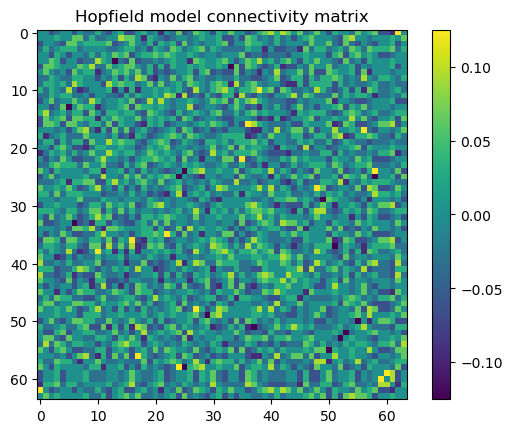

In [5]:
plt.figure()
plt.imshow(model.W, interpolation='none') #kwarg?
plt.colorbar()
plt.title("Hopfield model connectivity matrix")
plt.show()

In [13]:
def see_pattern(i):
    plt.figure()
    plt.yticks([])
    plt.title("pattern number %i" %(i))
    plt.imshow(patterns[i].reshape(int(np.sqrt(N)),int(np.sqrt(N))), cmap='binary') 
    plt.show()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

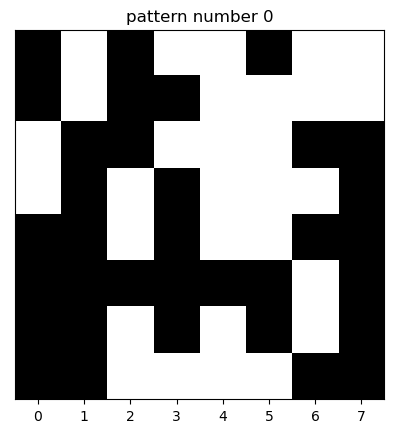

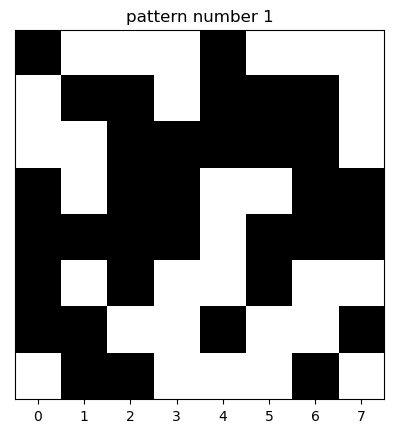

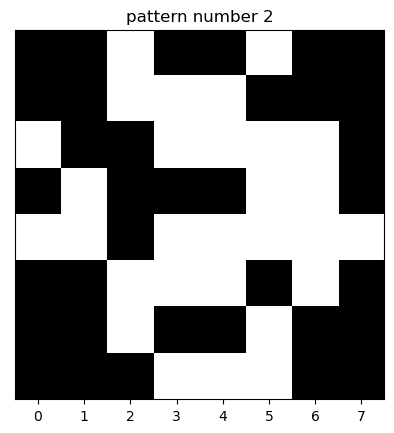

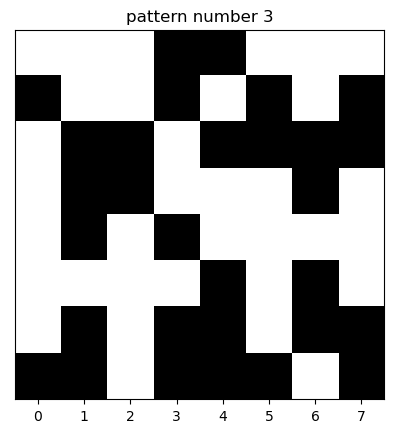

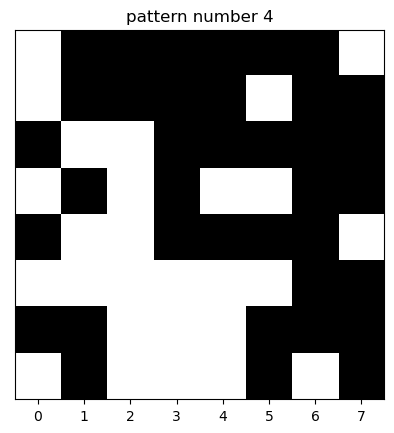

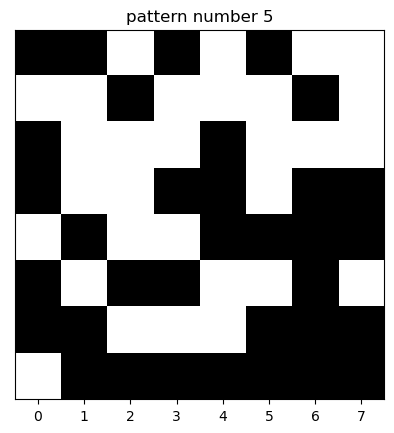

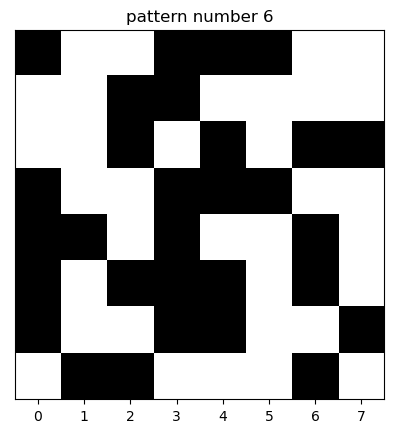

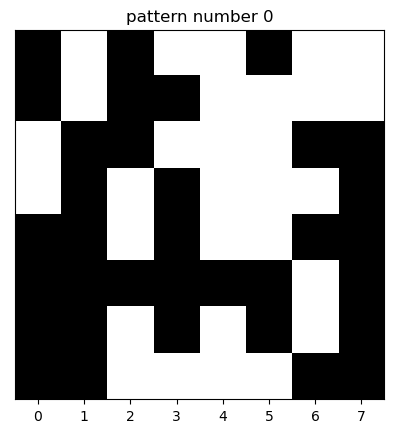

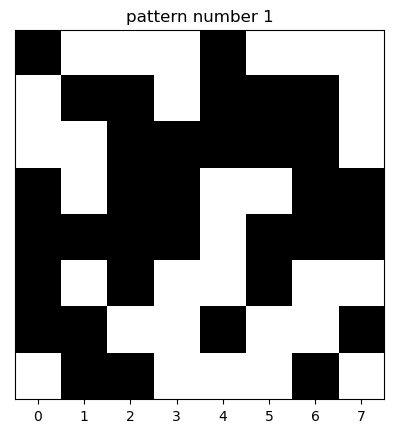

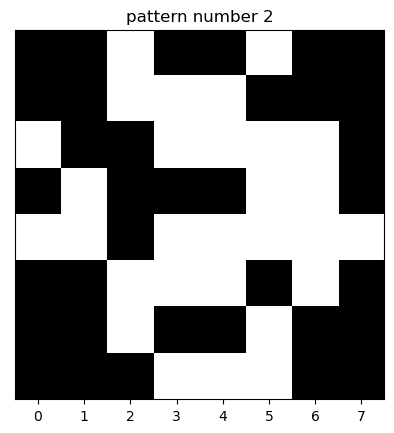

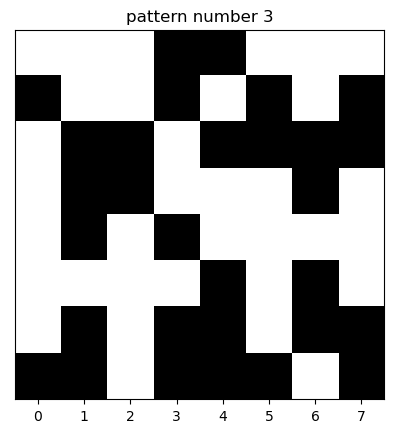

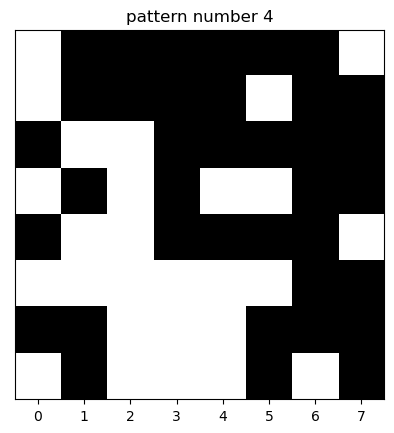

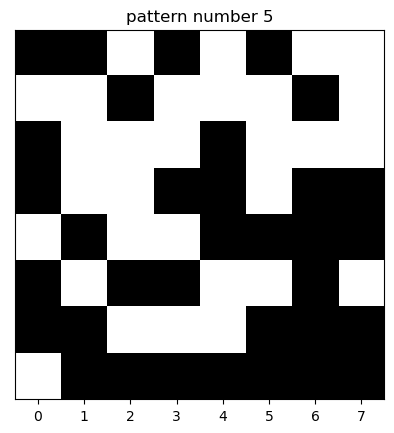

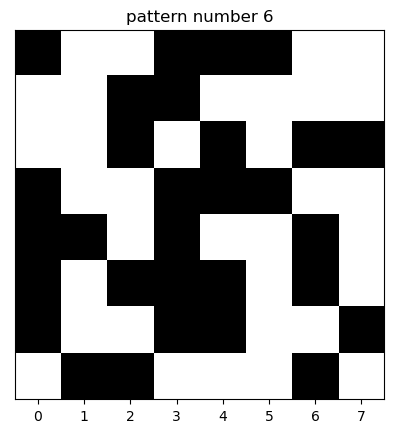

In [14]:
for i in range(k-1):
    see_pattern(i)

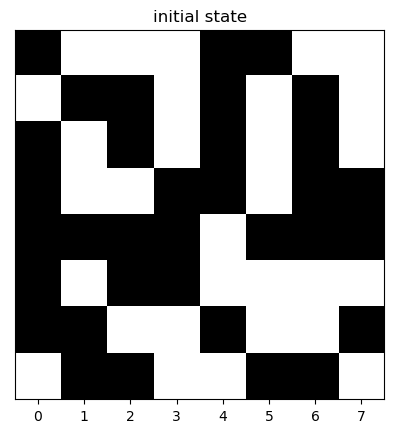

In [27]:
#####################
#test model retrieval 
#####################
#with a corrupted version of one of the stored patterns above

retrieve = patterns[5] 
S0 = patterns[5] 
flip = 3 #number of differing neurons (noise)
flip_selection = random.sample(range(N), flip)
S0[flip_selection] = -1*S0[flip_selection]

plt.imshow(S0.reshape(int(np.sqrt(N)),int(np.sqrt(N))), cmap='binary')
plt.yticks([])
plt.title("initial state")
plt.show()

In [28]:
iterations = 15
model.update_neurons(S0, iterations, "async")
output = model.states
label = identify_state(output, patterns)
#this tells us if the retrieved pattern is correct
print('Hamming distance between output and memory #', label,':', hamming_distance(output,retrieve))

Reached stable point after 3 iterations
Hamming distance between output and memory # 5 : 0


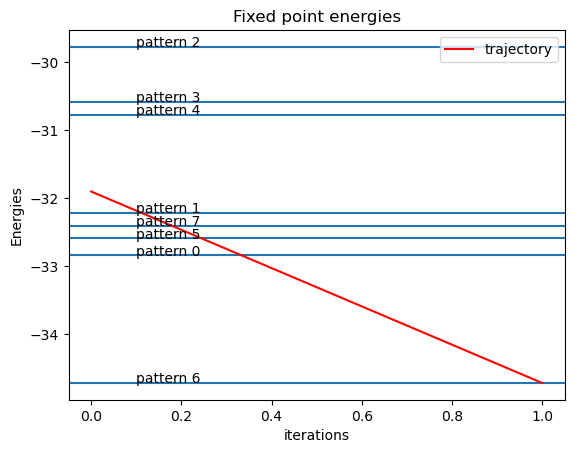

In [17]:
fixedpt_energies = [model.energy(el) for el in patterns]
for i in range(len(fixedpt_energies)):
    plt.axhline(fixedpt_energies[i])
    plt.annotate('pattern %i' %(i), xy=(0.1,fixedpt_energies[i]))
plt.title('Fixed point energies')

E = model.energies
plt.plot(E, color='r', label='trajectory')
plt.legend(loc='upper right')
plt.ylabel("Energies")
plt.xlabel("iterations")
plt.show()

In [18]:
def get_duplicate(fixedpt_energies):
    for el in fixedpt_energies:
        if fixedpt_energies.count(el) > 1:
            return el
duplicate = get_duplicate(fixedpt_energies)
dup_indices = [i for i,val in enumerate(fixedpt_energies) if val==duplicate]
print(fixedpt_energies, 'has duplicates in indices', dup_indices)

[-32.84375, -32.21875, -29.78125, -30.59375, -30.78125, -32.59375, -34.71875, -32.40625] has duplicates in indices []


In [19]:
# two patterns have the same energy, but how close are they ?
if len(dup_indices) > 0:
    see_pattern(dup_indices[0])
    see_pattern(dup_indices[1])
    print('Hamming distance between equipotential patterns:', hamming_distance(patterns[dup_indices[0]],patterns[dup_indices[1]]))

In [38]:
# repeat for various initial conditions 
#(patterns with some level of noise)
def retrieval(model, which, noise, mode, iters):
    retrieve = patterns[which] 
    S0 = patterns[which] 
    flip = noise 
    flip_selection = random.sample(range(N), flip)
    S0[flip_selection] = -1*S0[flip_selection]
    model.update_neurons(S0, iters, mode)
    output = model.states
    label = identify_state(output, patterns)
    print('Hamming distance between output and memory #', label,':', hamming_distance(output,retrieve), '\n')
    model.t = 0
    return output

#NOTE: async mode recalls exactly even with 50% noise (32 flips, just takes more iterations)
# but syncronous mode fails to retrieve the correct pattern
for i in range(k):
    output = retrieval(model, i, 50, "async", 15)

Reached stable point after 3 iterations
Hamming distance between output and memory # 6 : 0 

Reached stable point after 2 iterations
Hamming distance between output and memory # 1 : 0 

Reached stable point after 3 iterations
Hamming distance between output and memory # 4 : 0 

Reached stable point after 2 iterations
Hamming distance between output and memory # 3 : 0 

Reached stable point after 2 iterations
Hamming distance between output and memory # 4 : 0 

Reached stable point after 3 iterations
Hamming distance between output and memory # 5 : 0 

Reached stable point after 2 iterations
Hamming distance between output and memory # 6 : 0 

Reached stable point after 2 iterations
Hamming distance between output and memory # 7 : 0 



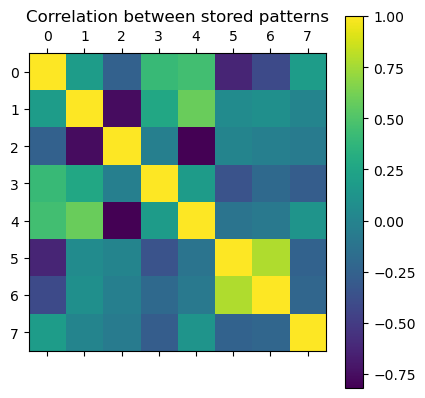

In [24]:
data = { 
    'x1': patterns[1],'x2': patterns[2],'x3': patterns[3],
    'x4': patterns[4],'x5': patterns[5],'x6': patterns[6],
    'x7': patterns[7], 'x0': patterns[0]
}
df = pd.DataFrame(data, columns=['x0','x1','x2','x3','x4','x5','x6','x7'])
corr_mat = df.corr()
plt.matshow(corr_mat)
plt.title("Correlation between stored patterns")
plt.colorbar()
plt.show()

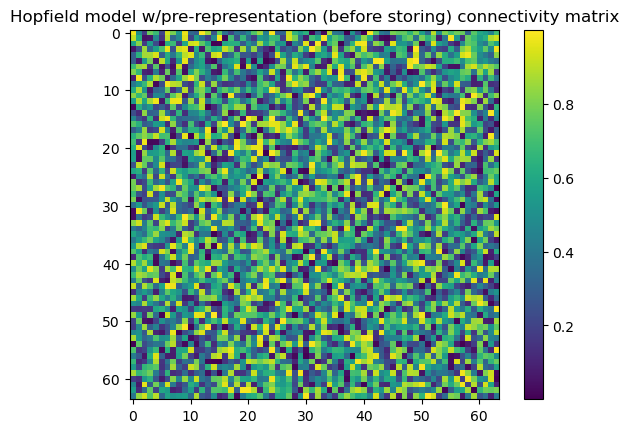

In [29]:
################# Different model initialization ####################
#let's see if giving some structure to the weights of the network
#before storing patterns makes them more distinct in energy landscape
model_preRep = HopfieldNet(N, np.random.rand(N,N))

plt.figure()
plt.imshow(model_preRep.W, interpolation='none') #kwarg?
plt.colorbar()
plt.title("Hopfield model w/pre-representation (before storing) connectivity matrix")
plt.show()

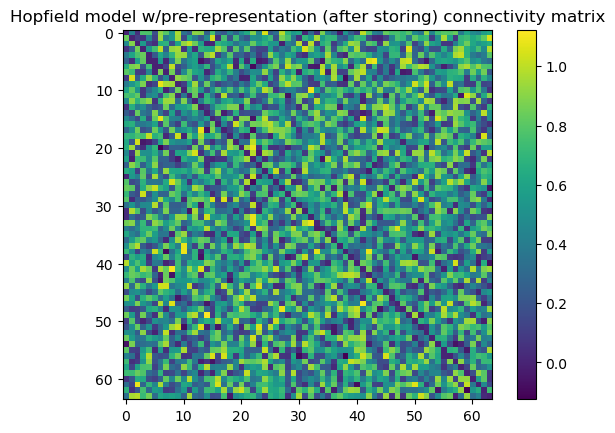

In [30]:
model_preRep.train_data(patterns)

plt.figure()
plt.imshow(model_preRep.W, interpolation='none') #kwarg?
plt.colorbar()
plt.title("Hopfield model w/pre-representation (after storing) connectivity matrix")
plt.show()

In [34]:
noise_level = 3
for i in range(k):
    output = retrieval(model_preRep, i, noise_level, "async",15)

Reached stable point after 2 iterations
Hamming distance between output and memory # 0 : 0 

Reached stable point after 2 iterations
Hamming distance between output and memory # 1 : 0 

Reached stable point after 2 iterations
Hamming distance between output and memory # 2 : 0 

Reached stable point after 2 iterations
Hamming distance between output and memory # 3 : 0 

Reached stable point after 2 iterations
Hamming distance between output and memory # 4 : 0 

Reached stable point after 2 iterations
Hamming distance between output and memory # 5 : 0 

Reached stable point after 2 iterations
Hamming distance between output and memory # 6 : 0 

Reached stable point after 2 iterations
Hamming distance between output and memory # 7 : 0 



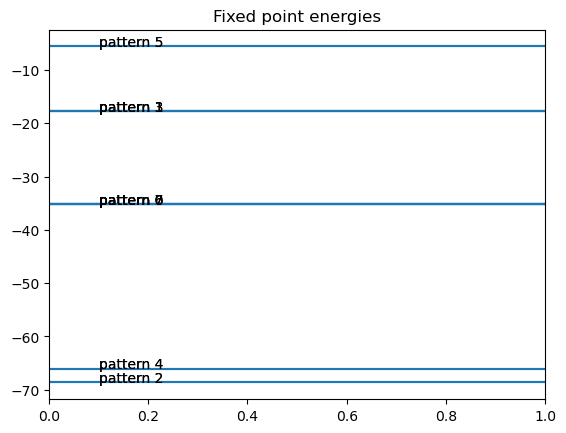

In [41]:
fixedpt_energies = [model_preRep.energy(el) for el in patterns]
for i in range(len(fixedpt_energies)):
    plt.axhline(fixedpt_energies[i])
    plt.annotate('pattern %i' %(i), xy=(0.1,fixedpt_energies[i]))
plt.title('Fixed point energies')
plt.show()

In [42]:
duplicate = get_duplicate(fixedpt_energies)
dup_indices = [i for i,val in enumerate(fixedpt_energies) if val==duplicate]
print(fixedpt_energies, 'has duplicates in indices', dup_indices)

[-35.14656991441426, -17.786590997679646, -68.6562274666588, -17.786590997679646, -66.042226237385, -5.582694761256796, -35.14656991441426, -35.14656991441426] has duplicates in indices [0, 6, 7]


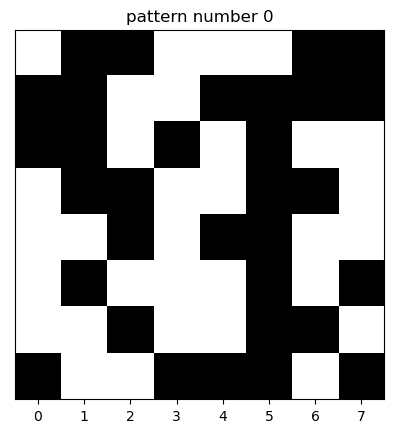

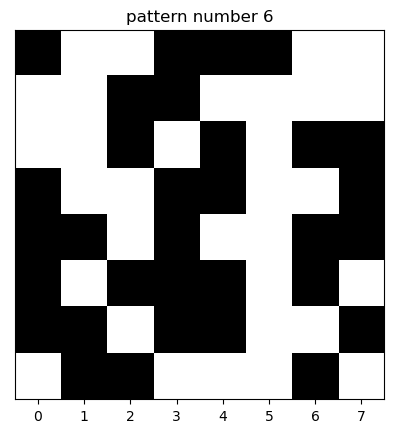

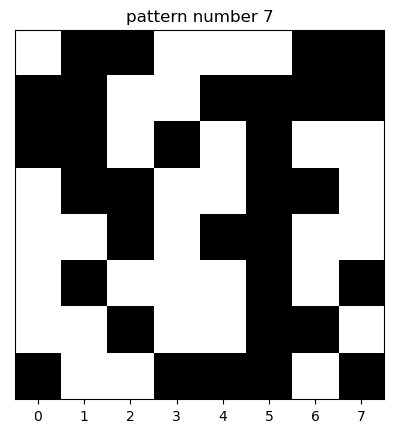

Hamming distance between two equipotential patterns: 64


In [45]:
if len(dup_indices) > 0:
    for i in range(len(dup_indices)):
        see_pattern(dup_indices[i])
    print('Hamming distance between two equipotential patterns:', hamming_distance(patterns[dup_indices[0]],patterns[dup_indices[1]]))

In [46]:
#patterns are being overwritten ?!

[array([-1,  1,  1, -1, -1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,
         1, -1,  1, -1,  1, -1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1, -1,
         1, -1,  1,  1, -1, -1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1,  1,
        -1, -1,  1,  1, -1,  1, -1, -1,  1,  1,  1, -1,  1]),
 array([-1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1,  1,
        -1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1, -1,
         1, -1,  1,  1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,
        -1,  1, -1, -1, -1, -1,  1,  1,  1,  1,  1, -1, -1]),
 array([ 1, -1, -1,  1, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1,  1,
        -1, -1, -1,  1, -1,  1, -1,  1, -1, -1,  1,  1, -1,  1,  1,  1,  1,
        -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1,  1, -1,  1,  1, -1,
        -1, -1,  1, -1,  1, -1,  1,  1, -1, -1, -1,  1, -1]),
 array([-1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1,  1,
        -1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1